In [1]:
!pip install tensorflow==1.15.3
!pip install umap-learn
!pip install umap-learn[plot]
!pip install cvae
!pip install hdbscan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 110.5 MB 20 kB/s 
     |████████████████████████████████| 50 kB 3.2 MB/s 
     |████████████████████████████████| 3.8 MB 30.6 MB/s 
     |████████████████████████████████| 503 kB 40.0 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=2b18a3f2e6b658ad7ae4639ea6d08906a82923b58d513a71739ce6cc8b2eee8a
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting un

In [2]:

import pandas as pd
import numpy as np

import umap
import umap.plot

import matplotlib.pyplot as plot
import seaborn as sns

from sklearn import metrics
from collections import Counter

import tensorflow as tf
tf.enable_eager_execution()
import tensorflow_hub as tf_hub

In [3]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('./drive/MyDrive/preprocessed-data.csv')
df.head()

Mounted at /content/drive


,label,text
0,rec.sport.hockey,pens fans pretty confused lack kind posts rece...
1,comp.sys.ibm.pc.hardware,brother market high performance video card sup...
2,talk.politics.mideast,finally dream mediterranean area greater holoc...
3,comp.sys.ibm.pc.hardware,scsi card doing dma transfers disks scsi card ...
4,comp.sys.mac.hardware,[number] old drive cannot understanding driver...


In [5]:
embed_module = "https://tfhub.dev/google/universal-sentence-encoder/4"
embeddings = tf_hub.load(embed_module)

def embed_data(input):
  return embeddings([input])

# Applying embedding to text
df['sentence_embedding'] = df['text'].apply(embed_data)

# Dataframe after sentence embedding
df.head()

,label,text,sentence_embedding
0,rec.sport.hockey,pens fans pretty confused lack kind posts rece...,"((tf.Tensor(-0.039444216, shape=(), dtype=floa..."
1,comp.sys.ibm.pc.hardware,brother market high performance video card sup...,"((tf.Tensor(-0.039467365, shape=(), dtype=floa..."
2,talk.politics.mideast,finally dream mediterranean area greater holoc...,"((tf.Tensor(-0.057665743, shape=(), dtype=floa..."
3,comp.sys.ibm.pc.hardware,scsi card doing dma transfers disks scsi card ...,"((tf.Tensor(0.04853781, shape=(), dtype=float3..."
4,comp.sys.mac.hardware,[number] old drive cannot understanding driver...,"((tf.Tensor(-0.052863352, shape=(), dtype=floa..."


In [6]:
# Taking the sentence embeddings as input
X = df.iloc[:,2].values
X[0].shape

X_new = np.array([x.numpy() for x in X]).reshape((df.shape[0],512))
X_new.shape

(18270, 512)

Cluster Number: 2
Homogeneity: 0.571
Completeness: 0.268
V-measure: 0.365
Adjusted Rand-Index: 0.003
Silhouette Coefficient: -0.093
Cluster Number: 3
Homogeneity: 0.470
Completeness: 0.267
V-measure: 0.341
Adjusted Rand-Index: 0.003
Silhouette Coefficient: -0.196
Cluster Number: 4
Homogeneity: 0.424
Completeness: 0.276
V-measure: 0.335
Adjusted Rand-Index: 0.009
Silhouette Coefficient: -0.164
Cluster Number: 5
Homogeneity: 0.404
Completeness: 0.300
V-measure: 0.344
Adjusted Rand-Index: 0.021
Silhouette Coefficient: -0.204
Cluster Number: 6
Homogeneity: 0.424
Completeness: 0.337
V-measure: 0.375
Adjusted Rand-Index: 0.080
Silhouette Coefficient: -0.089
Cluster Number: 7
Homogeneity: 0.414
Completeness: 0.338
V-measure: 0.372
Adjusted Rand-Index: 0.063
Silhouette Coefficient: -0.092
Cluster Number: 8
Homogeneity: 0.415
Completeness: 0.364
V-measure: 0.388
Adjusted Rand-Index: 0.107
Silhouette Coefficient: -0.078
Cluster Number: 9
Homogeneity: 0.409
Completeness: 0.370
V-measure: 0.388
Ad

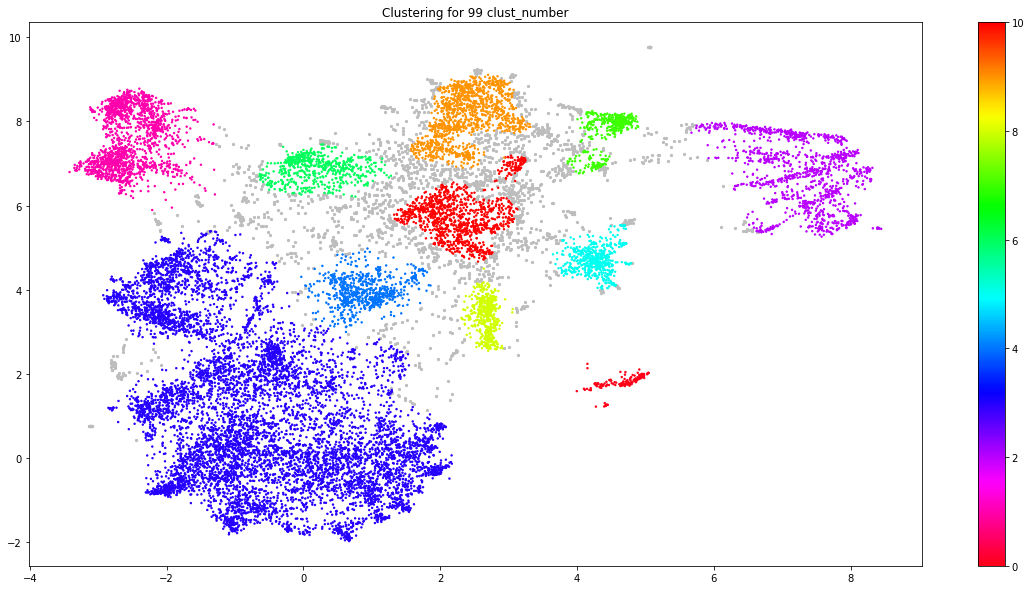

<Figure size 432x288 with 0 Axes>

In [7]:
import hdbscan

cluster_number = 2
plot_number = 1

while cluster_number < 100:
    print("Cluster Number:", cluster_number)
    hdb = hdbscan.HDBSCAN(min_cluster_size=cluster_number)
    embedding = umap.UMAP(n_components=2).fit(X_new)
    umap_data = embedding.fit_transform(X_new)
    cluster = hdb.fit(umap_data)
    yhat = cluster.labels_

    # Prepare data
    umap_data = umap_data
    result = pd.DataFrame(umap_data, columns=['x', 'y'])
    result['labels'] = cluster.labels_
    print("Homogeneity: %0.3f" % metrics.homogeneity_score(df.label, yhat))
    print("Completeness: %0.3f" % metrics.completeness_score(df.label, yhat))
    print("V-measure: %0.3f" % metrics.v_measure_score(df.label, yhat))
    print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(df.label, yhat))
    print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(umap_data, yhat, sample_size=1000))

    # Visualize clusters
    outliers = result.loc[result.labels == -1, :]
    clustered = result.loc[result.labels != -1, :]
    if cluster_number == 99:
      plot.figure(figsize=(20, 10))
      plot.title(f" Clustering for {cluster_number} cluster")
      plot.scatter(outliers.x, outliers.y, color='#BDBDBD', s=5)
      plot.scatter(clustered.x, clustered.y, c=clustered.labels, s=2, cmap='hsv_r')
      plot.colorbar()
      plot.show()
    plot_number += 1
    cluster_number += 1
    
plot.tight_layout()

In [9]:
print("EVALUATION METRICS")
print("Homogeneity: %0.3f" % metrics.homogeneity_score(df.label, yhat))
print("Completeness: %0.3f" % metrics.completeness_score(df.label, yhat))
print("V-measure: %0.3f" % metrics.v_measure_score(df.label, yhat))
print("Adjusted Rand-Index: %.3f"
  % metrics.adjusted_rand_score(df.label, yhat))
print("Silhouette Coefficient: %0.3f"
  % metrics.silhouette_score(umap_data, yhat, sample_size=1000))

EVALUATION METRICS
Homogeneity: 0.317
Completeness: 0.493
V-measure: 0.385
Adjusted Rand-Index: 0.132
Silhouette Coefficient: 0.343


In [11]:
umap_embedding = umap.UMAP(n_components=2).fit(X_new)
umap_data = umap_embedding.fit_transform(X_new)



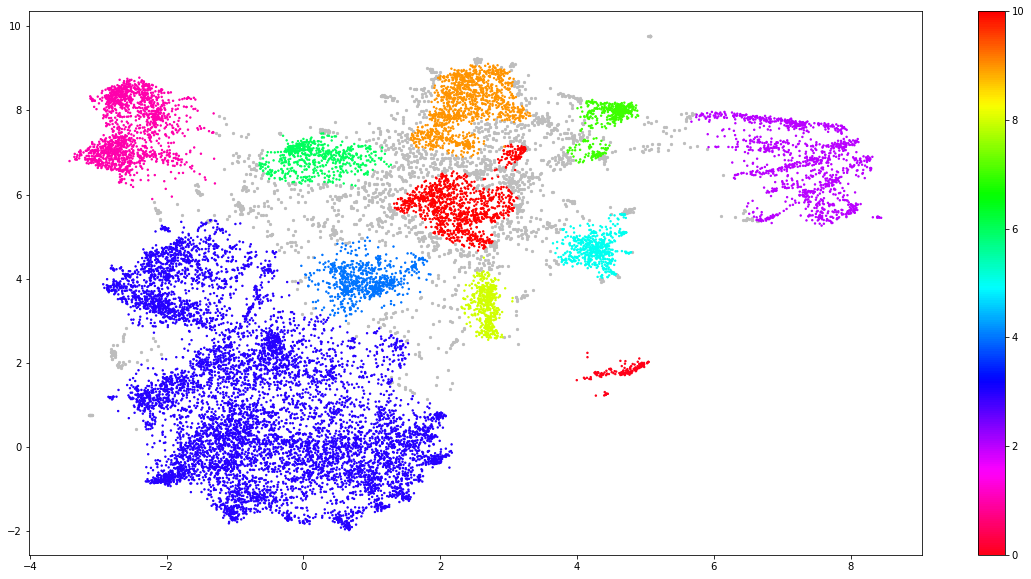

In [12]:
plot.figure(figsize=(20, 10))
plot.scatter(outliers.x, outliers.y, color='#BDBDBD', s=5)
plot.scatter(clustered.x, clustered.y, c=clustered.labels, s=2, cmap='hsv_r')
plot.colorbar()
plot.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


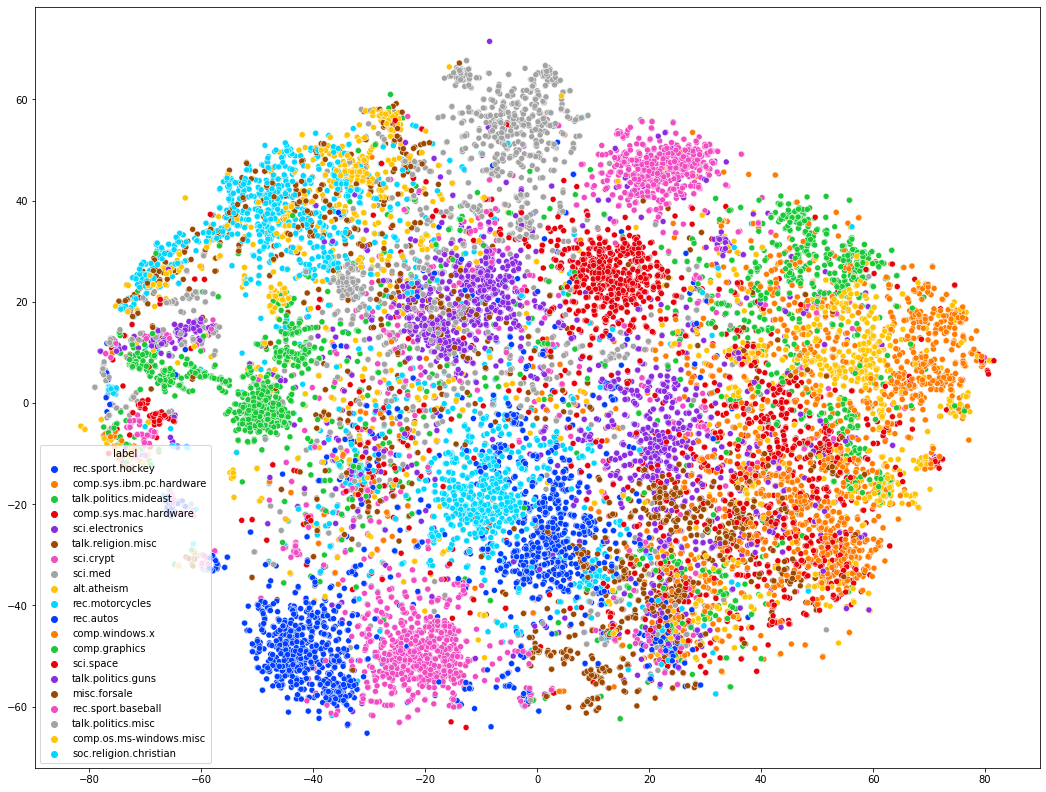

In [14]:
# TSNE Visualization
from sklearn.manifold import TSNE
tsne = TSNE()
X_embedded = tsne.fit_transform(X_new)
palette = sns.color_palette("bright", 20)
plot.figure(figsize=(18,14))
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=df['label'], palette=palette)

In [15]:
# CVAE Visualization
from cvae import cvae
cvae_embedder = cvae.CompressionVAE(X_new)
# Train the model 
cvae_embedder.train()

Total amount of data:  16443
Input feature dimension:  512
Calculating normalisation factors.
Normalisation factors calculated.
Total amount of data:  1827
Creating model.
Model created.
Setting up loss.
Loss set up.
Setting up session.
Session set up.
Trying to restore saved checkpoints from /content/temp ... No checkpoint found.
No model found to restore. Initialising new model.
Starting queues.
Reader threads started.
step 0; epoch 0.00 - loss = 257.712, test_loss = 262.148, lr = 0.00100, (0.026 sec/step)
Storing checkpoint to /content/temp ... Done.
step 50; epoch 0.19 - loss = 257.503, test_loss = 260.175, lr = 0.00100, (0.006 sec/step)
step 100; epoch 0.39 - loss = 252.245, test_loss = 258.483, lr = 0.00100, (0.006 sec/step)
step 150; epoch 0.58 - loss = 249.773, test_loss = 253.838, lr = 0.00100, (0.006 sec/step)
step 200; epoch 0.78 - loss = 246.571, test_loss = 243.914, lr = 0.00100, (0.006 sec/step)
step 250; epoch 0.97 - loss = 241.652, test_loss = 242.599, lr = 0.00100, (0.

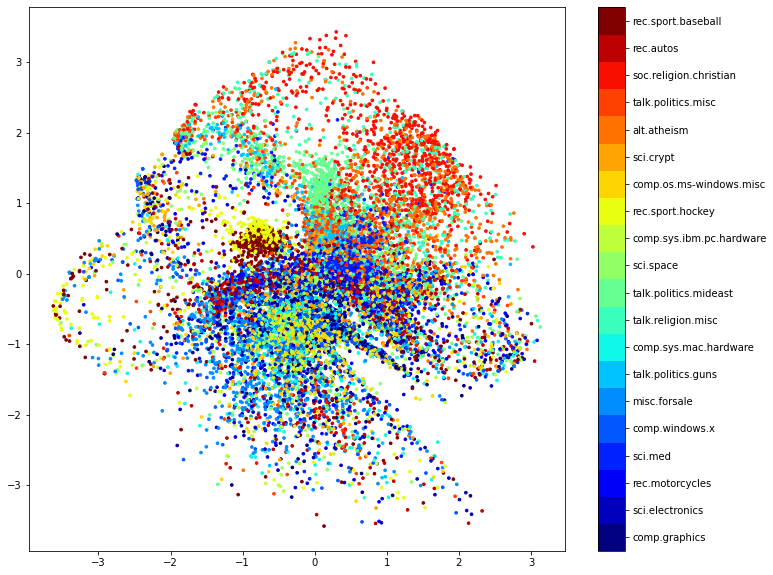

In [16]:
z = cvae_embedder.embed(X_new)
cvae_embedder.visualize(z, labels=df['label'].values)